<a href="https://colab.research.google.com/github/Harshit-077/PytorchML/blob/main/RiceProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/mssmartypants/rice-type-classification")

Skipping, found downloaded files in "./rice-type-classification" (use force=True to force download)


In [37]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)


cuda


In [38]:
data_df = pd.read_csv('/content/rice-type-classification/riceClassification.csv')
data_df.head()

,id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,1,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,4,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,5,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [39]:
data_df.dropna(inplace = True)
data_df.drop(['id'], axis = 1, inplace = True)
print(data_df.shape)

(18185, 11)


In [40]:
print(data_df['Class'].unique())

[1 0]


In [41]:
print(data_df['Class'].value_counts())

Class
1    9985
0    8200
Name: count, dtype: int64


In [42]:
original_df = data_df.copy()

for column in data_df.columns:
  data_df[column] = data_df[column] / data_df[column].abs().max()
data_df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,0.444368,0.503404,0.775435,0.744658,0.424873,0.666610,0.741661,0.537029,0.844997,0.368316,1.0
1,0.281293,0.407681,0.622653,0.750489,0.273892,0.530370,0.804230,0.409661,0.919215,0.371471,1.0
2,0.298531,0.416421,0.630442,0.756341,0.284520,0.546380,0.856278,0.412994,0.959862,0.374747,1.0
3,0.300979,0.420463,0.629049,0.764024,0.286791,0.548616,0.883772,0.414262,0.961818,0.379222,1.0
4,0.361704,0.464626,0.682901,0.775033,0.345385,0.601418,0.867808,0.452954,0.966836,0.386007,1.0


In [43]:
X = np.array(data_df.iloc[:, :-1]) #iloc[rows, column] all rows all columns except last
Y = np.array(data_df.iloc[:, -1]) #iloc[rows, column] all rows only last column

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size = 0.3)

In [45]:
X_test, X_val, y_test, y_val = train_test_split(X_test,y_test,test_size = 0.5)

In [46]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(12729, 10)
(2728, 10)
(2728, 10)


In [47]:
class dataset(Dataset):
  def __init__(self, X, Y):
    self.X = torch.tensor(X, dtype = torch.float32).to(device)
    self.Y = torch.tensor(Y, dtype = torch.float32).to(device)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, index):
    return self.X[index], self.Y[index]

In [48]:
training_data = dataset(X_train, y_train)
validation_data = dataset(X_val, y_val)
testing_data = dataset(X_test, y_test)

In [49]:
train_dataloader = DataLoader(training_data, batch_size = 32, shuffle = True)
validation_dataloader = DataLoader(validation_data, batch_size = 32, shuffle = True)
test_dataloader = DataLoader(testing_data, batch_size = 32, shuffle = True)

In [50]:
HIDDEN_NEURONS = 10
class MyModel(nn.Module):
  def __init__(self):
    super(MyModel, self).__init__()
    self.input_layer = nn.Linear(X.shape[1], HIDDEN_NEURONS)
    self.linear = nn.Linear(HIDDEN_NEURONS, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self,x):
    x = self.input_layer(x)
    x = self.linear(x)
    x = self.sigmoid(x)
    return x
model = MyModel().to(device)


In [51]:
summary(model,(X.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]             110
            Linear-2                    [-1, 1]              11
           Sigmoid-3                    [-1, 1]               0
Total params: 121
Trainable params: 121
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [52]:
print(model.forward)

<bound method MyModel.forward of MyModel(
  (input_layer): Linear(in_features=10, out_features=10, bias=True)
  (linear): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)>


In [53]:
criterion = nn.BCELoss() # Binary cross entropy loss
optimizer = Adam(model.parameters(), lr = 1e-3)

In [54]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

epochs = 10
for epoch in range(epochs):
  total_acc_train = 0
  total_loss_train = 0
  total_acc_val = 0
  total_loss_val = 0

  for data in train_dataloader:
    inputs, labels = data
    prediction = model(inputs).squeeze(1)

    batch_loss = criterion(prediction, labels)

    total_loss_train += batch_loss.item()

    acc = ((prediction).round() == labels).sum().item()
    total_acc_train += acc

    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
  with torch.no_grad():
    for data in validation_dataloader:
      inputs, labels = data
      prediction = model(inputs).squeeze(1)
      batch_loss = criterion(prediction, labels)

      total_loss_val += batch_loss.item()
      acc = ((prediction).round() == labels).sum().item()
      total_acc_val += acc
  total_loss_train_plot.append(round(total_loss_train/1000, 4))
  total_loss_validation_plot.append(round(total_loss_val/1000, 4))

  total_acc_train_plot.append(round(total_acc_train/training_data.__len__()* 100, 4))
  total_acc_validation_plot.append(round(total_acc_val/validation_data.__len__()* 100, 4))


  print(f'Epoch Number: {epoch+1} Train Loss: {total_loss_train} Train Accuracy: {round(total_acc_train/training_data.__len__()* 100, 4)} Validation Loss: {round(total_loss_val/1000, 4)} Validation Accuracy: {round(total_acc_val/validation_data.__len__()* 100, 4)}')
  print('='*25)


Epoch Number: 1 Train Loss: 237.88206443190575 Train Accuracy: 82.2138 Validation Loss: 0.0384 Validation Accuracy: 98.1305
Epoch Number: 2 Train Loss: 116.42177943885326 Train Accuracy: 97.6903 Validation Loss: 0.0156 Validation Accuracy: 98.3871
Epoch Number: 3 Train Loss: 53.70625488460064 Train Accuracy: 98.2795 Validation Loss: 0.009 Validation Accuracy: 98.4604
Epoch Number: 4 Train Loss: 34.390460504218936 Train Accuracy: 98.4602 Validation Loss: 0.0063 Validation Accuracy: 98.717
Epoch Number: 5 Train Loss: 26.61603731289506 Train Accuracy: 98.5466 Validation Loss: 0.0052 Validation Accuracy: 98.7537
Epoch Number: 6 Train Loss: 22.569961728528142 Train Accuracy: 98.5938 Validation Loss: 0.0046 Validation Accuracy: 98.717
Epoch Number: 7 Train Loss: 20.213470151647925 Train Accuracy: 98.6409 Validation Loss: 0.0042 Validation Accuracy: 98.717
Epoch Number: 8 Train Loss: 18.71297504985705 Train Accuracy: 98.6252 Validation Loss: 0.0039 Validation Accuracy: 98.717
Epoch Number: 9 

In [55]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for data in test_dataloader:
    inputs, labels = data
    prediction = model(inputs).squeeze(1)
    batch_loss_test = criterion(prediction, labels).item()
    total_loss_test += batch_loss_test

    acc = ((prediction).round() == labels).sum().item()
    total_acc_test += acc

print(f'Accuracy: {round(total_acc_test/testing_data.__len__()* 100, 4)}')



Accuracy: 98.5337


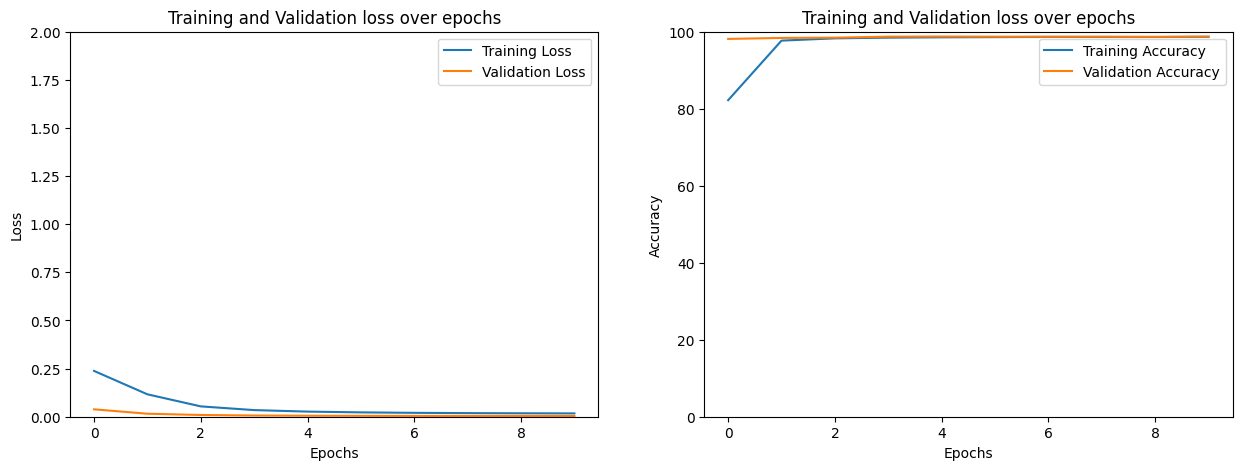

In [56]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))

axs[0].plot(total_loss_train_plot, label = "Training Loss")
axs[0].plot(total_loss_validation_plot, label = "Validation Loss")
axs[0].set_title("Training and Validation loss over epochs")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].set_ylim([0,2])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label = "Training Accuracy")
axs[1].plot(total_acc_validation_plot, label = "Validation Accuracy")
axs[1].set_title("Training and Validation loss over epochs")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
axs[1].set_ylim([0,100])
axs[1].legend()

plt.show()

In [60]:
area = 2945/original_df['Area'].abs().max()
MajorAxisLength = 81/original_df['MajorAxisLength'].abs().max()
MinorAxisLength = 42/original_df['MinorAxisLength'].abs().max()
Eccentricity = 45/original_df['Eccentricity'].abs().max()
ConvexArea = 12/original_df['ConvexArea'].abs().max()
EquivDiameter = 27/original_df['EquivDiameter'].abs().max()

Extent = 46/original_df['Extent'].abs().max()
Perimeter = 75/original_df['Perimeter'].abs().max()
Roundness = 36/original_df['Roundness'].abs().max()
AspectRation = 19/original_df['AspectRation'].abs().max()
my_prediction = model(torch.tensor([area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation],dtype=torch.float32).to(device))

In [62]:
my_prediction.item()

1.0